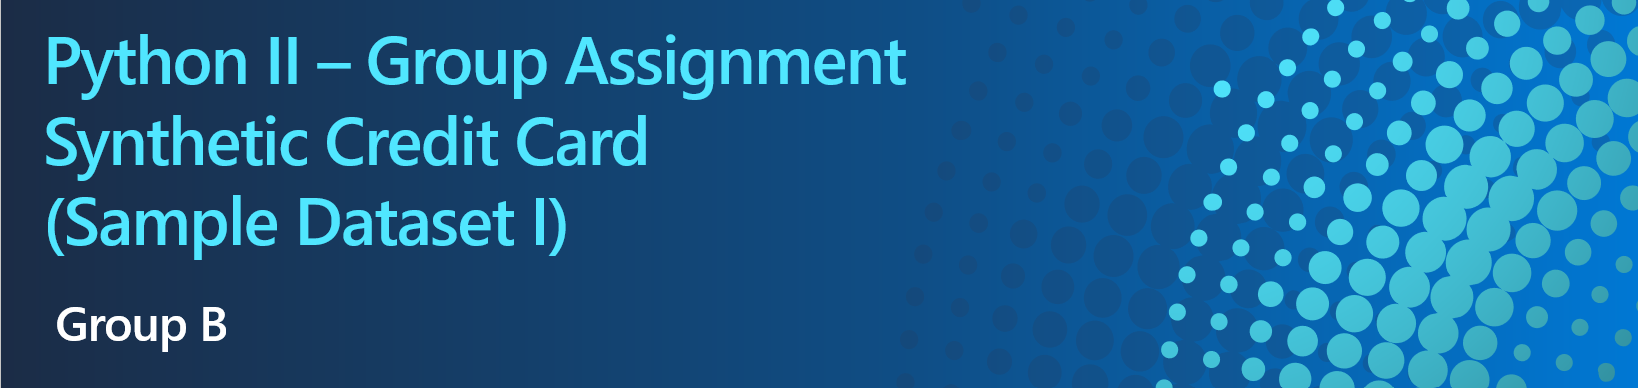

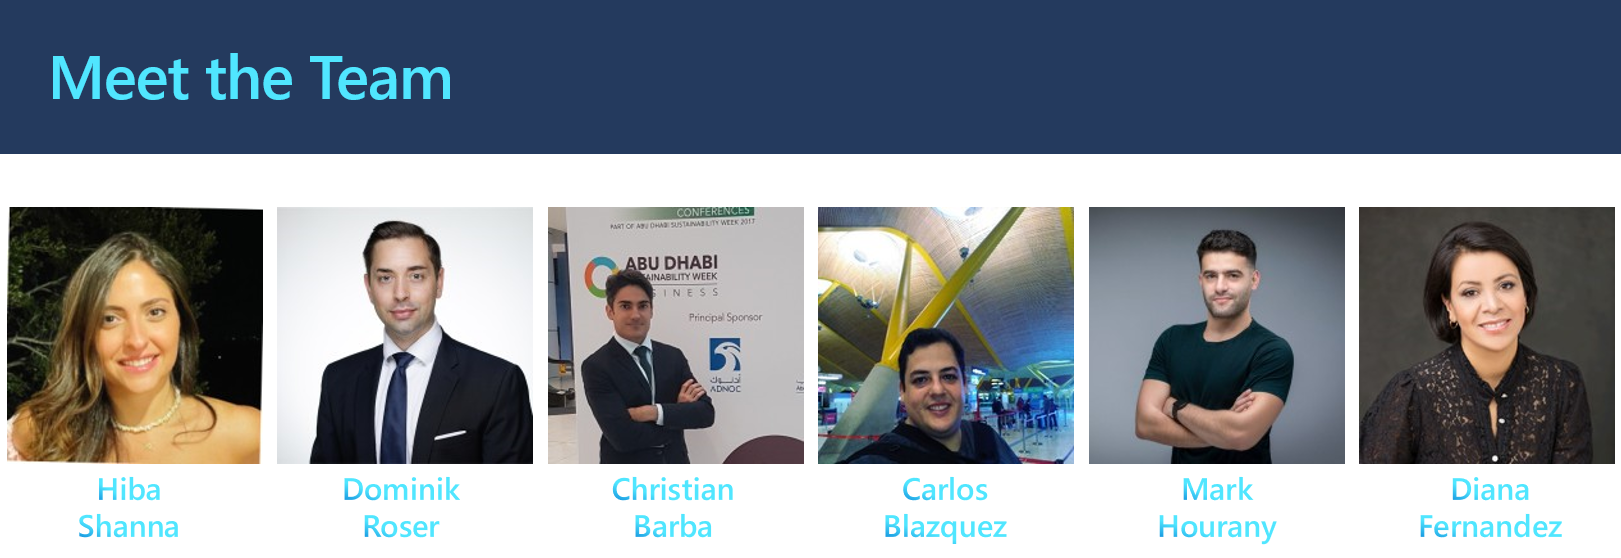


# An approach to detecting and understanding Machine Learning Biases using classes

## Table of Contents

* [The Synthetic Credit Card Dataset](#0)
* [1. FairDetect Framework](#1)
* [2. Aequitas Framework](#2)

<a id='1'></a>
# The Syntetic Credit Card DataSet

The dataset contains, for each applicant:

- Income (in the Income column),
- The number of children (in the Num_Children column),
- Whether the applicant owns a car (in the Own_Car column, the value is 1 if the applicant owns a car, and is else 0), and
- Whether the applicant owns a home (in the Own_Housing column, the value is 1 if the applicant owns a home, and is else 0)
- When evaluating fairness, we'll check how the model performs for users in different groups, as identified by the Group column:

The Group column breaks the users into two groups (where each group corresponds to either 0 or 1).

For instance, you can think of the column as breaking the users into two different races, ethnicities, or gender groupings. If the column breaks users into different ethnicities, 0 could correspond to a Hispanic user, while 1 corresponds to a non-Hispanic user.

<a id='1'></a>
# FairDetect Framework

Congregating the various theoretical concepts into a practical framework, we can follow the “theoretical lens of a ‘sense-plan-act’ cycle”, as described by the HLEG framework (European Commission and Directorate-General for Communications Networks, Content and Technology, 2019). Applying this concept to the problem of ML fairness, we can break down three core steps in providing robust, and responsible artificial intelligence: Identify, Understand, and Act (IUA).

1. __Identify__: The process of exposing direct or indirect biases within a dataset and/or model.
1. __Understand__: The process of isolating impactful scenarios and obtaining trans parent explanations for outcomes.
1. __Act__: The process of reporting and rectifying identified disparities within the

By understanding the philosophical forms of unfairness as defined by our review of the literature and categorizing our prominent fairness metrics into the overarching categories of representation, ability, and performance, we can establish a series of tests to “identify” levels of disparities between sensitive groups at different levels. Merging these findings with the explainability of our models through the use of white-box models, or Shapley value estimation for black-box models, we can dig deeper into the model’s predictions, “understanding” how classifications were made, and how they varied from the natural dataset exposing both natural biases as well as added model differences. Finally, by probing further into levels of misclassification, in particular looking at negative outcomes, we can isolate groups most at risk and set up a series of “actions” that can be taken to mitigate the effects. Given this three-step framework which combines societal, legal, and technical considerations, the paper will then go through a series of cases, and examine the proposed framework.

## Using FairDetect functions to find biases

### Load the functions from fairdetect_functions

In [1]:
import time

start_time = time.time()

import matplotlib.pyplot as plt
from random import randrange
import numpy as np
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import dalex as dx
import pandas as pd
from scipy.stats import chi2_contingency
from tabulate import tabulate
from sklearn.metrics import confusion_matrix
from scipy.stats import chisquare
from sklearn.metrics import precision_score


class FairDetect:
    
    def __init__(self,model,X_test,y_test):
        self.model,self.X_test,self.y_test = model, X_test, y_test
    
    def check_for_target(self):
        """
        Target variable label definition. Only binary target variable accepted
        
        Return
        ------
        Selection of the target variable from all columns of the dataframe
        """
        print(data.columns.values)
        self.target_column = input("Please select target column")
        if not(set(data[self.target_column].unique())==set([0,1])):
            raise ValueError('Only binary target variable')
        else:
            print("You choose wisely. Your target variable is:", self.target_column)
        
        return self.target_column
    
    def check_for_sensitive(self):
        """
        Sensitive variable label definition. Only binary sensitive variable accepted
        
        Return
        ------
        Selection of the sensitive variable from all columns of the dataframe
        """
        print(data.columns.values)
        self.sensitive_column = input("Please select sensitive column")
        if not(set(data[self.sensitive_column].unique())==set([0,1])):
            raise ValueError('Only binary sensitive variable')
        else:
            print("You choose wisely. Your sensitive variable is:", self.sensitive_column)

        return self.sensitive_column   

     
    def create_labels(self,sensitive):
        """
        Sensitive variable label definition. Only binary target variable accepted
        
        Parameters
        ----------
        sensitive_label: Method allows user to input a string for each group of sensitive
        """
        sensitive_label = {}
        for i in set(X_test[sensitive]):
            text = "Please Enter Label for Group" +" "+ str(i)+": "
            label = input(text)
            sensitive_label[i]=label
        return(sensitive_label)
    
    def create_targetname(self,predictions):
        print()
        print("Enter Target names below") 
        target_name = {}
        for i in set(predictions):
            text = "Please Enter name for target predicted" +" "+ str(i)+": "
            name = input(text)
            target_name[i]=name
            #print(target_name)
        return(target_name)
    
    def get_sensitive_col(self):
        print("Please select the sensitive column name from given features")
        print(self.X_test.columns.values)
        sens_col=input("Enter sensitive column here : ")
        print()
        return sens_col

    
    def representation(self,X_test,y_test,sensitive,labels,predictions,target_names):
        full_table = X_test.copy()
        sens_df = {}

        for i in labels:
            full_table['p'] = predictions
            full_table['t'] = y_test
            sens_df[labels[i]] = full_table[full_table[sensitive]==i]
        
        #print(sens_df)
        
        contigency_p = pd.crosstab(full_table[sensitive], full_table['t']) 
        cp, pp, dofp, expectedp = chi2_contingency(contigency_p) 
        contigency_pct_p = pd.crosstab(full_table[sensitive], full_table['t'], normalize='index')

        sens_rep = {}
        for i in labels:
            sens_rep[labels[i]] = (X_test[sensitive].value_counts()/X_test[sensitive].value_counts().sum())[i]

        labl_rep = {}
        for i in labels:
            labl_rep[str(i)] = (y_test.value_counts()/y_test.value_counts().sum())[i]


        fig = make_subplots(rows=1, cols=2)

        for i in labels:
            fig.add_trace(go.Bar(
            showlegend=False,
            x = [labels[i]],
            y= [sens_rep[labels[i]]]),row=1,col=1)
            '''
            fig.add_trace(go.Bar(
            showlegend=False,
            x = [str(i)],
            y= [labl_rep[str(i)]],
            marker_color=['orange','blue'][i]),row=1,col=2) 
            '''
        #changed here
        for i in target_names:     
            
            fig.add_trace(go.Bar(
            showlegend=False,
            x = [target_names[i]],
            y= [labl_rep[str(i)]],
            marker_color=['orange','blue'][i]),row=1,col=2)

        c, p, dof, expected = chi2_contingency(contigency_p)
        
        # changed here
        cont_table = (tabulate(contigency_pct_p.T, headers=labels.values(),showindex= target_names.values(), tablefmt='fancy_grid'))

        return cont_table, sens_df, fig, p

    
    
    def ability(self,sens_df,labels):
        """
        Method to calculate ability bias for the sensitive group members
        
        Parameters
        ----------
        sens_df: model results df for based on the sensitive variable definition
        Labels: Labels definition for the sensitive variable
        
        Returns
        -------   
        TPR: True Positive Rate calculation
        FPR: False Positive Rate calculation
        TNR: True Negative Rate calculation 
        FNR: False Negative Rate calculation        
        """ 
        sens_conf = {}
        for i in labels:
            sens_conf[labels[i]] = confusion_matrix(list(sens_df[labels[i]]['t']), list(sens_df[labels[i]]['p']), labels=[0,1]).ravel()

        true_positive_rate = {}
        false_positive_rate = {}
        true_negative_rate = {}
        false_negative_rate = {}

        for i in labels:
            true_positive_rate[labels[i]] = (sens_conf[labels[i]][3]/(sens_conf[labels[i]][3]+sens_conf[labels[i]][2]))
            false_positive_rate[labels[i]] = (sens_conf[labels[i]][1]/(sens_conf[labels[i]][1]+sens_conf[labels[i]][0]))
            true_negative_rate[labels[i]] = 1 - false_positive_rate[labels[i]]
            false_negative_rate[labels[i]] = 1 - true_positive_rate[labels[i]]

        return(true_positive_rate,false_positive_rate,true_negative_rate,false_negative_rate)



    def ability_plots(self,labels,TPR,FPR,TNR,FNR):
        """
        Method to plot the results of the ability method leveraging bar charts
        
        Parameters
        ----------
        Labels: Labels definition for the sensitive variable
        TPR: True Positive Rate calculation result from abilty method 
        FPR: False Positive Rate calculation result from abilty method
        TNR: True Negative Rate calculation result from abilty method
        FNR: False Negative Rate calculation result from abilty method
        
        Returns
        -------   
        Bar charts supporting each of the scenarios above split by defined sensitive variable          
        """
        
        fig = make_subplots(rows=2, cols=2, 
                            subplot_titles=("True Positive Rate", "False Positive Rate", "True Negative Rate", "False Negative Rate"))

        x_axis = list(labels.values())
        fig.add_trace(
            go.Bar(x = x_axis, y=list(TPR.values())),
            row=1, col=1
        )

        fig.add_trace(
            go.Bar(x = x_axis, y=list(FPR.values())),
            row=1, col=2
        )

        fig.add_trace(
            go.Bar(x = x_axis, y=list(TNR.values())),
            row=2, col=1
        )

        fig.add_trace(
            go.Bar(x = x_axis, y=list(FNR.values())),
            row=2, col=2
        )

        fig.update_layout(showlegend=False,height=600, width=800, title_text="Ability Disparities")
        fig.show()


    def ability_metrics(self,TPR,FPR,TNR,FNR):
        """
        Method to calculate the Chi square test and p-value for each of the scenarios defined in the
        ability method
        
        Parameters
        ----------
        TPR: True Positive Rate calculation result from ability method 
        FPR: False Positive Rate calculation result from ability method
        TNR: True Negative Rate calculation result from ability method
        FNR: False Negative Rate calculation result from ability method
        
        Returns
        -------   
        P-value result of the hypothesis H0: No Significant ability bisparity. P-value is calculated 
        for each of the scenarios indicating level of disparity based on the following criteria in the case 
        of identifying disparity:
        
        If p-value <= 0.01 -> ***
        If p-value <= 0.05 -> **
        If p-value <= 0.1 -> *
        
        Cases in which the null hypothesis H0 is rejected are printed bold and underlined. 
        
        Notes
        ------
        The p-values are calculated using the Chi test-statistic         
        """
            
        self.TPR_p = chisquare(list(np.array(list(TPR.values()))*100))[1]
        self.FPR_p = chisquare(list(np.array(list(FPR.values()))*100))[1]
        self.TNR_p = chisquare(list(np.array(list(TNR.values()))*100))[1]
        self.FNR_p = chisquare(list(np.array(list(FNR.values()))*100))[1]

        if self.TPR_p <= 0.01:
            print('\033[1;4m' +"*** Reject H0: Significant True Positive Disparity with p="+'\033[0m',self.TPR_p)
        elif self.TPR_p <= 0.05:
            print('\033[1;4m' +"** Reject H0: Significant True Positive Disparity with p="+'\033[0m',self.TPR_p)
        elif self.TPR_p <= 0.1:
            print('\033[1;4m' +"*  Reject H0: Significant True Positive Disparity with p="+'\033[0m',self.TPR_p)
        else:
            print("Accept H0: True Positive Disparity Not Detected. p=",self.TPR_p)

        if self.FPR_p <= 0.01:
            print('\033[1;4m' +"*** Reject H0: Significant False Positive Disparity with p="+'\033[0m',self.FPR_p)
        elif self.FPR_p <= 0.05:
            print('\033[1;4m' +"** Reject H0: Significant False Positive Disparity with p="+'\033[0m',self.FPR_p)
        elif self.FPR_p <= 0.1:
            print('\033[1;4m' +"*  Reject H0: Significant False Positive Disparity with p="+'\033[0m',self.FPR_p)
        else:
            print("Accept H0: False Positive Disparity Not Detected. p=",self.FPR_p)

        if self.TNR_p <= 0.01:
            print('\033[1;4m' +"*** Reject H0: Significant True Negative Disparity with p="+'\033[0m',self.TNR_p)
        elif self.TNR_p <= 0.05:
            print('\033[1;4m' +"** Reject H0: Significant True Negative Disparity with p="+'\033[0m', self.TNR_p)
        elif self.TNR_p <= 0.1:
            print('\033[1;4m' +"*  Reject H0: Significant True Negative Disparity with p="+'\033[0m', self.TNR_p)
        else:
            print("Accept H0: True Negative Disparity Not Detected. p=",self.TNR_p)

        if self.FNR_p <= 0.01:
            print('\033[1;4m' +"*** Reject H0: Significant False Negative Disparity with p="+'\033[0m',self.FNR_p)
        elif self.FNR_p <= 0.05:
            print('\033[1;4m' +"** Reject H0: Significant False Negative Disparity with p="+'\033[0m',self.FNR_p)
        elif self.FNR_p <= 0.1:
            print('\033[1;4m' +"*  Reject H0: Significant False Negative Disparity with p="+'\033[0m',self.FNR_p)
        else:
            print("Accept H0: False Negative Disparity Not Detected. p=",self.FNR_p)




    def predictive(self,labels,sens_df):
        
        """
        This method calculates disparity between the orignal model and the predicted model
        
        Parameters
        ----------
        sens_df: model results df for based on the sensitive variable definition
        Labels: Labels definition for the sensitive variable
        
        Returns
        -------   
        Bar charts indicating predictive disparity level split by defined sensitive variable 
        P-value result of the hypothesis H0: No Significant Predictive Disparity
        
        Notes
        ------
        The p-values are calculated using the Chi test-statistic         
        """
        precision_dic = {}

        for i in labels:
            precision_dic[labels[i]] = precision_score(sens_df[labels[i]]['t'],sens_df[labels[i]]['p'])

        fig = go.Figure([go.Bar(x=list(labels.values()), y=list(precision_dic.values()))])

        pred_p = chisquare(list(np.array(list(precision_dic.values()))*100))[1]

        return(precision_dic,fig,pred_p)

    
         
    def identify_bias(self, sensitive,labels):
        
        """
        This method summarizes the areas of bias within FairDetect framework.
        
        Parameters
        ----------
        Sensitive: Defined sensitive variable to be analyzed.
        Labels: Labels definition for the sensitive variable
        
        Returns
        -------
        Breakdown of Bias identification into 3 categories
        
        Representation: Representation of the sensitive variables and its association with 
        the target variable and the p-values associated in order to identify representation disparity
        
        Ability: Compares the ability for the sensitive group members
        
        Predictive: Compares the distribution within the data set and the prediction set
        
        Notes
        ------
        The p-values are calculated using the Chi test-statistic
        """
        
        
        predictions = self.model.predict(self.X_test)
        
        ####
        #change 3
        #labels=self.create_labels(sensitive)
        target_names=self.create_targetname(predictions)
        
        ####
        print()
        
        cont_table,sens_df,rep_fig,rep_p = self.representation(self.X_test,self.y_test,sensitive,labels,predictions,target_names)

        print("REPRESENTATION")
        rep_fig.show()

        print(cont_table,'\n')

        if rep_p <= 0.01:
            print('\033[1;4m' +"*** Reject H0: Significant Relation Between",sensitive,"and Target with p="+'\033[0m',rep_p)
        elif rep_p <= 0.05:
            print('\033[1;4m' +"** Reject H0: Significant Relation Between",sensitive,"and Target with p="+'\033[0m',rep_p)
        elif rep_p <= 0.1:
            print('\033[1;4m' +"* Reject H0: Significant Relation Between",sensitive,"and Target with p="+'\033[0m',rep_p)
        else:
            print("Accept H0: No Significant Relation Between",sensitive,"and Target Detected. p=",rep_p)

        TPR, FPR, TNR, FNR = self.ability(sens_df,labels)
        print("\n\nABILITY")
        self.ability_plots(labels,TPR,FPR,TNR,FNR)
        self.ability_metrics(TPR,FPR,TNR,FNR)


        precision_dic, pred_fig, pred_p = self.predictive(labels,sens_df)
        print("\n\nPREDICTIVE")
        pred_fig.show()

        if pred_p <= 0.01:
            print('\033[1;4m'+"*** Reject H0: Significant Predictive Disparity with p="+'\033[0m',pred_p)
        elif pred_p <= 0.05:
            print('\033[1;4m'+"** Reject H0: Significant Predictive Disparity with p="+'\033[0m',pred_p)
        elif pred_p <= 0.1:
            print('\033[1;4m'+"* Reject H0: Significant Predictive Disparity with p="+'\033[0m',pred_p)
        else:
            print("Accept H0: No Significant Predictive Disparity. p=",pred_p)
    
 
    def disparate_impact(self,sensitive, labels):
        
        """
        Disparate impact is the ratio of unfavoured/favoured groups only considering occurences with the desired outcome
        
        Parameters
        ----------
        Sensitive: Defined sensitive variable to be analyzed.
        Labels: Labels definition for the sensitive variable
        
        Returns
        -------
        Plots for each one of the available combinations sensitive vs. target variables
        
        """
        
        actual_test_table = self.X_test.copy()
        actual_test_table['t'] = self.y_test
        actual_test_table['p'] = self.model.predict(self.X_test)
        
        favoured_df = actual_test_table[actual_test_table[sensitive] == 0]
        num_of_favoured = favoured_df.shape[0]
        unfavoured_df = actual_test_table[actual_test_table[sensitive] == 1]
        num_of_unfavoured = unfavoured_df.shape[0]
        
        positive_outcomes_favoured = favoured_df[favoured_df['t'] ==1].shape[0]
        positive_ratio_favoured = positive_outcomes_favoured/num_of_favoured
        
        positive_outcomes_unfavoured = unfavoured_df[unfavoured_df['t'] ==1].shape[0]
        positive_ratio_unfavoured = positive_outcomes_unfavoured/num_of_unfavoured
                           
        disparate_impact = positive_ratio_unfavoured / positive_ratio_favoured
        print("Disparate Impact, Sensitive vs. Predicted Target: " + str(disparate_impact))
        
        if disparate_impact <= 0.8:
            print('\033[1;4m'+"The disparate impact ratio is below 0.8 indicating a favour towards the priviliged group"+'\033[0m')
        elif disparate_impact <= 0.9:
            print("The disparate impact ratio indicates a slight favour towards the priviliged group")
        else: 
            print("The disparate impact ratio indicated complete equality between the favoured and unfavoured group")
            
        plt.bar('Ratio',disparate_impact)
        plt.title('Disparate impact')
        plt.xlabel('Ratio for postive outcomes for favoured and unfavoured groups')
        plt.ylabel('disparate_impact')
        plt.show()


    def understand_shap(self,labels,sensitive,affected_group,affected_target):
        
        """
        This method supports analysis of the differentiate the bias on the affected group vs. the overall population 
        and looks to understand what variables are the source of biggest disparity
        
        Parameters
        ----------
        Sensitive: Defined sensitive variable to be analyzed.
        Labels: Labels definition for the sensitive variable
        Affected_group: defined impacted group as per sensitive variable definition
        Affected_target: defined unpriviledge group as per target variable definition
        
        Returns
        -------
        Plots for each one of the available combinations sensitive vs. target variables compared to the base scenario: 
        variable relevance for all sensitive groups and all targets
        """       
            
        #labels=self.create_labels(sensitive)
        
        import shap
        explainer = shap.Explainer(self.model)

        full_table = self.X_test.copy()
        full_table['t'] = self.y_test
        full_table['p'] = self.model.predict(self.X_test)
        full_table

        shap_values = explainer(self.X_test)
        sens_glob_coh = np.where(self.X_test[sensitive]==list(labels.keys())[0],labels[0],labels[1])

        misclass = full_table[full_table.t != full_table.p]
        affected_class = misclass[(misclass[sensitive] == affected_group) & (misclass.p == affected_target)]
        shap_values2 = explainer(affected_class.drop(['t','p'],axis=1))
        #sens_mis_coh = np.where(affected_class[sensitive]==list(labels.keys())[0],labels[0],labels[1])


        figure,axes = plt.subplots(nrows=2, ncols=2,figsize=(20,10))
        plt.subplots_adjust(right=1.4,wspace=1)

        print("Model Importance Comparison")
        plt.subplot(1, 2, 1) # row 1, col 2 index 1
        shap.plots.bar(shap_values.cohorts(sens_glob_coh).abs.mean(0),show=False)
        plt.subplot(1, 2, 2) # row 1, col 2 index 1
        shap_values2 = explainer(affected_class.drop(['t','p'],axis=1))
        shap.plots.bar(shap_values2)
        #shap.plots.bar(shap_values2)

        full_table['t'] = self.y_test
        full_table['p'] = self.model.predict(self.X_test)
        #full_table=full_table[['checking_account','credit_amount','duration','sex','t','p']]

        misclass = full_table[full_table.t != full_table.p]
        affected_class = misclass[(misclass[sensitive] == affected_group) & (misclass.p == affected_target)]

        truclass = full_table[full_table.t == full_table.p]
        tru_class = truclass[(truclass[sensitive] == affected_group) & (truclass.t == affected_target)]

        x_axis = list(affected_class.drop(['t','p',sensitive],axis=1).columns)
        affect_character = list((affected_class.drop(['t','p',sensitive],axis=1).mean()-tru_class.drop(['t','p',sensitive],axis=1).mean())/affected_class.drop(['t','p',sensitive],axis=1).mean())

        #plt.figsize([10,10])
        #plt.bar(x_axis,affect_character)

        fig = go.Figure([go.Bar(x=x_axis, y=affect_character)])

        print("Affected Attribute Comparison")
        print("Average Comparison to True Class Members")
        fig.show()

        misclass = full_table[full_table.t != full_table.p]
        affected_class = misclass[(misclass[sensitive] == affected_group) & (misclass.p == affected_target)]

        #truclass = full_table[full_table.t == full_table.p]
        tru_class = full_table[(full_table[sensitive] == affected_group) & (full_table.p == affected_target)]

        x_axis = list(affected_class.drop(['t','p',sensitive],axis=1).columns)
        affect_character = list((affected_class.drop(['t','p',sensitive],axis=1).mean()-full_table.drop(['t','p',sensitive],axis=1).mean())/affected_class.drop(['t','p',sensitive],axis=1).mean())

        #plt.figsize([10,10])
        #plt.bar(x_axis,affect_character)

        fig = go.Figure([go.Bar(x=x_axis, y=affect_character)])
        print("Average Comparison to All Members")
        fig.show()

        print("Random Affected Decision Process")
        explainer = shap.Explainer(self.model)
        shap.plots.waterfall(explainer(affected_class.drop(['t','p'],axis=1))[randrange(0, len(affected_class))],show=False)
        
end_time = time.time()

print("time taken in execution is :", end_time - start_time)

time taken in execution is : 1.3268077373504639


In [2]:
FairDetect

__main__.FairDetect

In [3]:
#First important relevant methods to run sql alchemy
import sqlalchemy as db
from sqlalchemy import create_engine
import pandas as pd
from sqlalchemy import inspect
from sqlalchemy import Column, Integer, DateTime
import datetime

class store_pvalues:
    
    def __init__(self,p_TPR,p_FPR,p_TNR,p_FNR):
        self.p_TRP,self.p_FPR,self.p_TNR,self.p_FNR = p_TPR,p_FPR,p_TNR,p_FNR

    
    def dynamic_data_entry(self,p_TPR,p_FPR,p_TNR,p_FNR):
        """
        Method to insert pvalues of TPR, FRP, TNR and FNR in dynamic way into a table
        
        
        Parameter
        -------   
        p_TPR: p value of True Positive Rate calculation
        p_FPR: p value of False Positive Rate calculation
        p_TNR: p value of True Negative Rate calculation 
        p_FNR: p value of False Negative Rate calculation        
        """
        query = db.insert(pvalues).values(Id=123, p_TPR = self.p_TRP, p_FPR = self.p_FPR, p_TNR = self.p_TNR, p_FNR = self.p_FNR) 
        ResultProxy = connection.execute(query)

### Load relevant libraries 

In [4]:
# Importing our Libraries

import matplotlib.pyplot as plt
from random import randrange
import numpy as np
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import dalex as dx
import pandas as pd
from scipy.stats import chi2_contingency
from tabulate import tabulate
from sklearn.metrics import confusion_matrix
from scipy.stats import chisquare
from sklearn.metrics import precision_score
#import fairdetect_functions as fd
from __future__ import print_function
import sqlite3

### Load Synthetic Credit Card Approval dataset

In [5]:
# Loading our DataFrame
# Loading our DataFrame
data = pd.read_csv('synthetic_credit_card_approval.csv')
data

,Num_Children,Group,Income,Own_Car,Own_Housing,Target
0,4,0,36151,0,0,0
1,0,0,36095,1,0,0
2,2,1,62110,1,1,0
3,0,1,73644,1,0,0
4,3,0,99146,0,0,1
...,...,...,...,...,...,...
499995,1,0,43299,1,1,0
499996,8,1,75956,1,1,1
499997,3,0,66476,0,0,0
499998,2,1,74524,0,0,0


In [6]:
data.dtypes

Num_Children    int64
Group           int64
Income          int64
Own_Car         int64
Own_Housing     int64
Target          int64
dtype: object

In [7]:
data_ae = data.copy()

In [8]:
data_bd = data.copy()

### Exploring data

In [9]:
#!pip install pandas-profiling
# uncomment this cell to install it

In [97]:
from pandas_profiling import ProfileReport
report = ProfileReport(data_bd, minimal=False)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Setting Target

In [10]:
target = FairDetect.check_for_target(data_bd)
# INSERT: Target

['Num_Children' 'Group' 'Income' 'Own_Car' 'Own_Housing' 'Target']
Please select target columnTarget
You choose wisely. Your target variable is: Target


### Splitting the data into train and test

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
X = data_bd.drop([target],axis=1) # axis: {0 or ‘index’, 1 or ‘columns’}, default 0
y = data_bd[target]

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8, test_size=0.2, random_state=0)
print("Data sucessfully loaded!")

Data sucessfully loaded!


### Training a machine learning model

In [12]:
#pip install xgboost

In [13]:
import xgboost
model = xgboost.XGBClassifier().fit(X_train, y_train)
y_test_predict = model.predict(X_test)
y_test_predict

array([1, 0, 0, ..., 0, 0, 1])

### Creating the Object

In [14]:
bd = FairDetect(model,X_test,y_test)

### Bias Detection


#### Representation of Sensitive Variables

In [16]:
sensitive=bd.get_sensitive_col()
labels=bd.create_labels(sensitive)
bd.identify_bias(sensitive,labels)
#INSERT label 1: hispanic
#INSERT in label 2: non_hispanic


Please select the sensitive column name from given features
['Num_Children' 'Group' 'Income' 'Own_Car' 'Own_Housing']
Enter sensitive column here : Group

Please Enter Label for Group 0: Yesssss
Please Enter Label for Group 1: Noooo

Enter Target names below
Please Enter name for target predicted 0: Shuuu
Please Enter name for target predicted 1: Okkk

REPRESENTATION


╒═══════╤═══════════╤══════════╕
│       │   Yesssss │    Noooo │
╞═══════╪═══════════╪══════════╡
│ Shuuu │  0.804943 │ 0.423006 │
├───────┼───────────┼──────────┤
│ Okkk  │  0.195057 │ 0.576994 │
╘═══════╧═══════════╧══════════╛ 

*** Reject H0: Significant Relation Between Group and Target with p= 0.0


ABILITY


Accept H0: True Positive Disparity Not Detected. p= 0.7159221552842456
Accept H0: False Positive Disparity Not Detected. p= 0.588169391004731
Accept H0: True Negative Disparity Not Detected. p= 0.9319949919140254
Accept H0: False Negative Disparity Not Detected. p= 0.1040665041132579


PREDICTIVE


Accept H0: No Significant Predictive Disparity. p= 0.700437584401918


In [ ]:
#Storing the most recent p-value out of the True Positive Disparity Rate, the False Positive Disparity Rate, the True Negative Rate and the False Negative Disparity Rate in variables
p_TPR = bd.TPR_p
p_FPR = bd.FPR_p
p_TNR = bd.TNR_p
p_FNR = bd.FNR_p

While the dataset has a balanced representation of each of the sensitive groups (50% each), the target variable, the credit allocation, shows a 61-39% distribution.
As it can be seen in the contingency table, the breakdown of each of the groups does not follow the initial distribution, with the following outcomes:
- only 20% of the hispanics in the sample have received a credit card 
- compared to 58% of approved credit card for non-hispanics

This clear unabalance triggers the chi square test (rejects null hypotheis) confirming there seems to be a singificant relation between the group and the outcome. 

In the Ability module which analyzes the confusion matrix: 
- the groups seems balanced in the TPR 93% for Hispanic vs 98% for non-Hispanic.
- In relation to the TNR, the model behaves pretty similarly for both categories: 98 vs 97%.
- FPR have a result of slightly below 2% FPR for Hispanics and a 3% for non-Hispanic. 
- the FNR is the less balanced of the 4 metrics with a 7% for Hispanic and a 2% for non-hispanic

The conclusion of the chi square test on the equalized odds is that there is no disparity in the ability of the classes as shown by the acceptance of the null hypothesis in the 4 cases (TPR,TNR,FPR,FNR).  

Finally, in the predictive section, the precision scores obtained for each group are 92.4% for Hispanics and 97.7 for non-Hispanics. The Chi square test indicates there is no significant disparity in the results of the prediction as compared to the distribution of the data set.  

### Saving to SQL lite3

In case we want to calculate further with the KPIs of the fairdetect method at a later stage and do not want to call of the fuctions above, we could store the intermediate results in SQLite.

In [ ]:
#First important relevant methods to run sql alchemy
import sqlalchemy as db
from sqlalchemy import create_engine
import pandas as pd
from sqlalchemy import inspect
from sqlalchemy import Column, Integer, DateTime
import datetime

We first create the database credict card approval for all tables related to the dataset. Then we connect to the database and create the table pvalues that should store the pvalues of TPR, TNR, FPR and FNR. 

In [ ]:
engine = db.create_engine('sqlite:///credit_card_approval.db') #Create credit_card approval.sqlite automatically
connection = engine.connect() #connect database
metadata = db.MetaData()

pvalues = db.Table('pvalues', metadata,
              db.Column('Id', db.Integer()),
              db.Column('date', db.types.DateTime(timezone=True), default=datetime.datetime.utcnow),
              db.Column('p_TPR', db.Float(), default=100.0),
              db.Column('p_FPR', db.Float(), default=100.0),
              db.Column('p_TNR', db.Float(), default=100.0),
              db.Column('p_FNR', db.Float(), default=100.0)
              )

metadata.create_all(engine) #Command to create the table

Through the inspector method it is possible to check which tables are in the respective database and which columns the tables have

In [ ]:
inspector = inspect(engine)
connection = engine.connect()
#printing the name of the table to check if it was successfully created
print(inspector.get_table_names())

In [ ]:
#printing the columns 
print(pvalues.columns.keys())

Furthermore we can also look at the metadata of the table and see what type of columns it has. 

In [ ]:
#showing the metadata of the sql alchemy table
print(repr(metadata.tables['pvalues']))

After the table was successfully created, we follow the same methodology as in fairdetect to first create the object of data entry and then enter the dynamic data itself. 

In [ ]:
p_value_object = store_pvalues(p_TPR,p_FPR,p_TNR,p_FNR)

We then call the object with the respective method of data entry and hand over the most recent p-values of TRP, FPR, TNR, FNR that resulted from the fairdetect analysis

In [ ]:
insert_data = p_value_object.dynamic_data_entry(p_TPR,p_FPR,p_TNR,p_FNR)

In order to check if the data was inserted we check for the most recent data entries in the database of credict card approval and print the latest five results

In [ ]:
query = db.select([pvalues]) 
ResultProxy = connection.execute(query)
ResultSet = ResultProxy.fetchall()
ResultSet[:5]

#### Disparate impact

The disparate impact is a metric to evalute the fairness. 
It differentiates between an unpriviliged/unfavoured group and a priviliged/favoured group. 
In the calculation is the proporition of the unpriviliged/unfavoured group that receives the positive outcome of the event, 
divided by the proporiton of priviliged group that receiveds the positive outcome. 

The results is interpreted by the four-fifths rule: if the unprivileged group has a less positive outcome than 80% compared
to the priviliged group there a diparate impact violation. 

In this analysis we also defined that a ratio of 80-90% is a sign of mild impact violation. A ratio of 1 is an indication for perfect equality. 



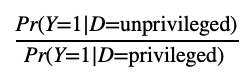

In [ ]:
bd.disparate_impact(sensitive,labels)


## Model Importance Comparison

In [ ]:
bd.understand_shap(labels,sensitive,0,0)

Despite the first analysis has not detected significant bias in the results, we are going to deepdive for group 0 (hispanic) that have miscorrectly been rejected the credit card (placed in target 0 instead of in target 1)

Overall we see the model gives slightly more importance to income for Hispanics as opposed to non-hispanics while the other parameters have roughly the same impact. 

Focusing now on the non-Hispanic group wrongly classified in group 0, we can see that all parameters have the same relative importance however income has a really smaller contribution or in other words, has been undervalued for the positive outcome. 

This can be noticed also in the comparison with the true positives class, where we see that false negatives tend to have a much bigger income than true positive of 22.4%.

Comparing the non-hispanic false negatives with all the group, the caracteristic that appears as more differential is that they tend to own a house.    

Looking at a specific individual, we see that not owning a house and a car have impacted more on the classification on group 0 instead of group 1, while being non-hispanic has had a positive impact that has not been able to compensate the previously indicated factors.    



<a id='3'></a>
## 2. AEQUITAS FRAMEWORK

We are now ready to utilize AEQUITAS to detect bias. 

The Aequitas toolkit is a flexible bias-audit utility for algorithmic decision-making models, accessible via Python API. It will help us out evaluate the performance of the model across several bias and fairness metrics. Here are the steps involved:

1) Understand where biases exist in Synthetic Credit Card dataset and in the model

2) Compare the level of bias between groups in our sample population (bias disparity)

3) Assess model Fairness and Visualize absolute bias metrics and their related disparities for rapid comprehension and decision-making




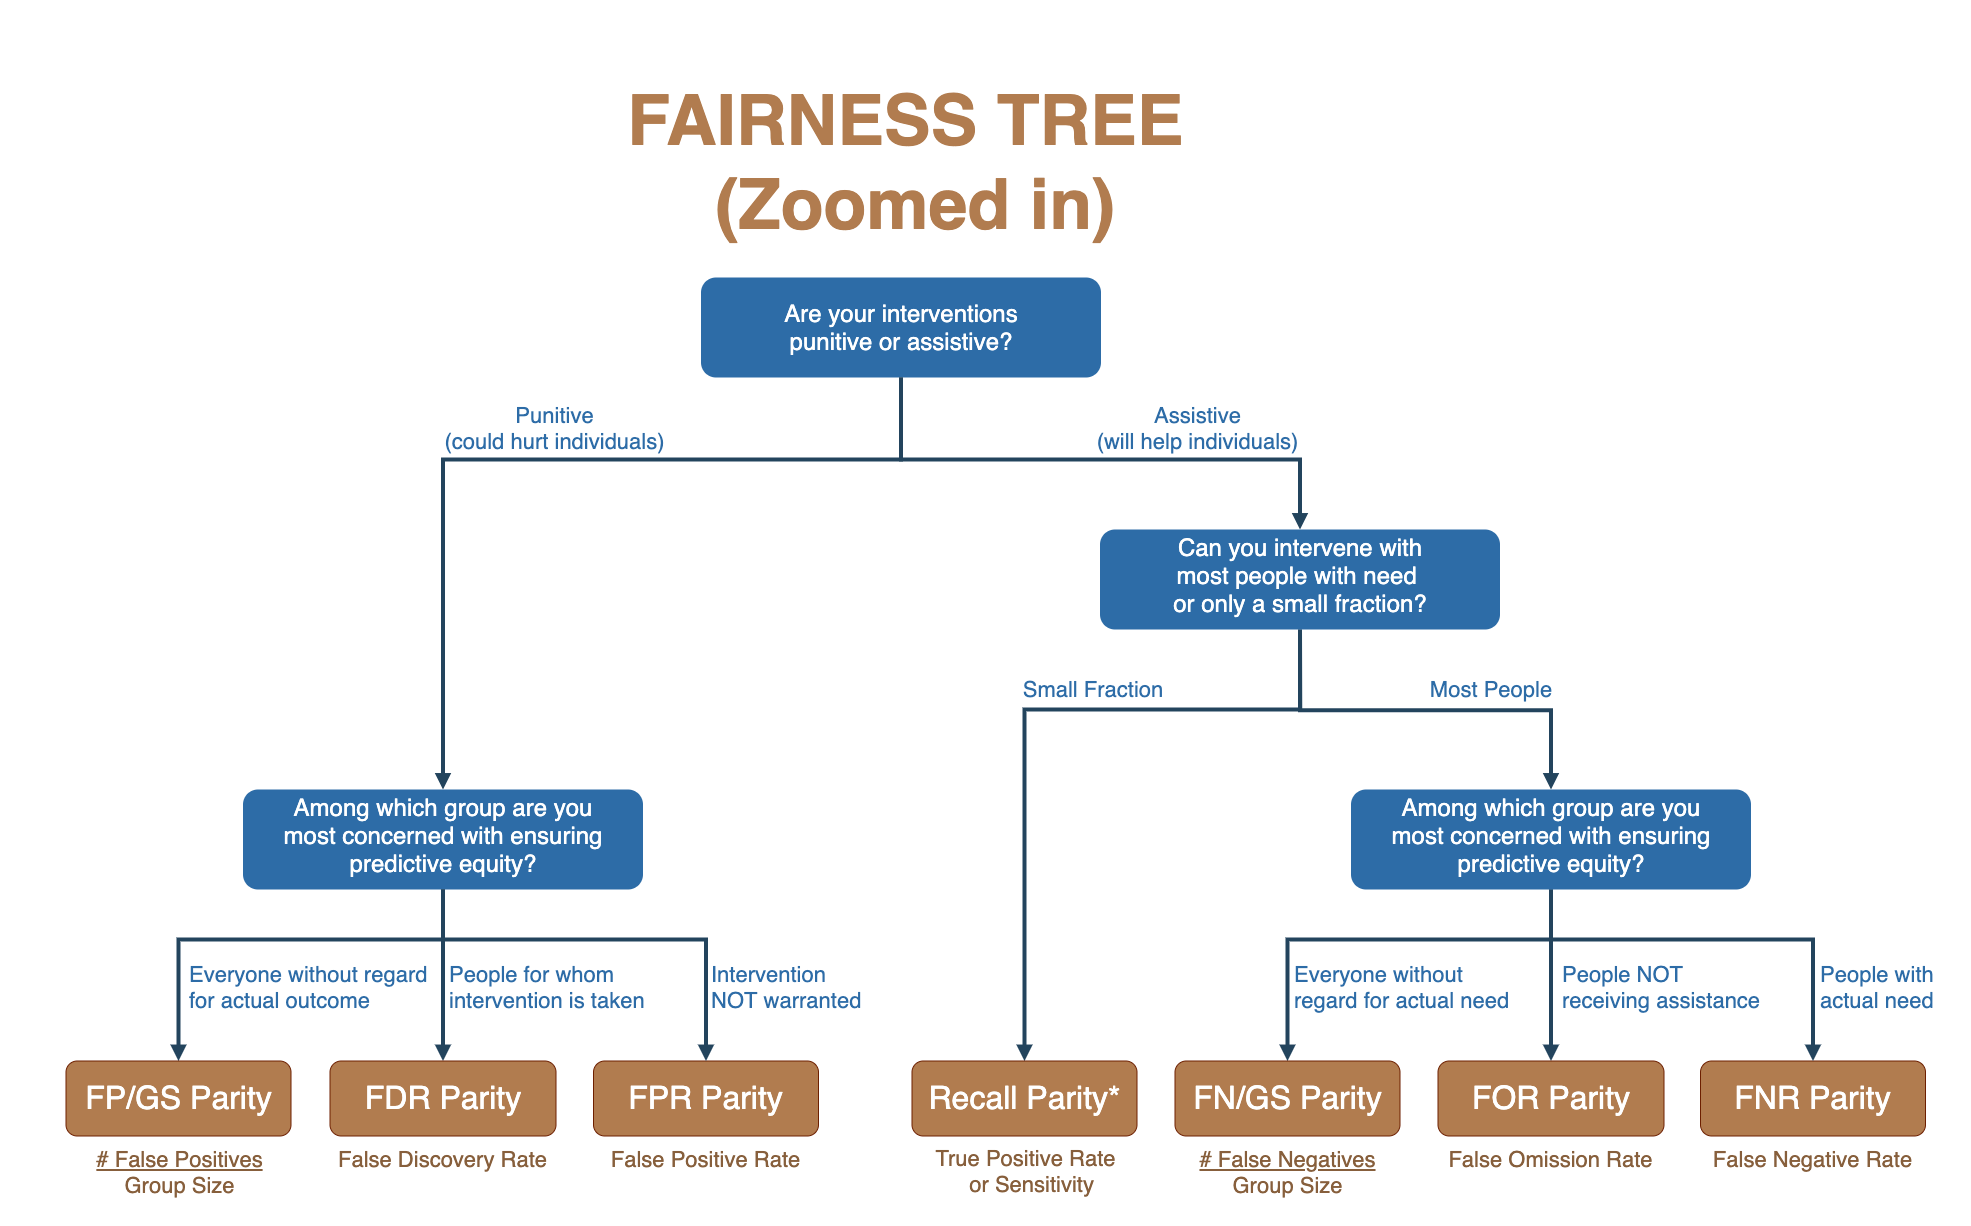

### Import Statements

As with any Python program, the first step will be to import the necessary packages. Below we import several components from the Aequitas package. We also import some other non-Aequitas useful packages.

In [ ]:
#!pip install aequitas
import pandas as pd
import seaborn as sns
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot
import aequitas.plot as ap
import warnings; warnings.simplefilter('ignore')

%matplotlib inline

### Reformatting the DF as required by Aequitas:

In [ ]:
aequitas_df=X_test.copy()
aequitas_df['score']=y_test_predict
aequitas_df['label_value']=y_test
#aequitas_df.rename(columns={}, inplace=True)
aequitas_df.head()
X_test.head()

In [ ]:
aequitas_df['Num_Children'] = aequitas_df['Num_Children'].map({0:'None', 1:'1 to 3' , 2:'1 to 3', 3:'1 to 3', 4:'4 to 7', 5:'4 to 7', 6:'4 to 7', 7:'4 to 7', 8:'8 or more'}) 
aequitas_df['Own_Car'] = aequitas_df['Own_Car'].map({0:'No', 1:'Yes'}) 
aequitas_df['Own_Housing'] = aequitas_df['Own_Housing'].map({0:'No', 1:'Yes'}) 
aequitas_df['Group'] = aequitas_df['Group'].map({0:'hispanic', 1:'non_hispanic'}) 
aequitas_df.head()

In [ ]:
from sklearn.preprocessing import FunctionTransformer

bins=[0, 65000, 85000, 350000]
labels=['low', 'medium', 'high']

transformer = FunctionTransformer(
    pd.cut, kw_args={'bins': bins, 'labels': labels, 'retbins': False})

aequitas_df['Income'] = transformer.fit_transform(aequitas_df['Income'])
aequitas_df.head()

In [ ]:
aequitas_df=aequitas_df[['score', 'label_value', 'Num_Children', 'Group', 'Income', 'Own_Car', 'Own_Housing']]
aequitas_df.head()

In [ ]:
aequitas_df.dtypes

In [ ]:
aequitas_df['Income']=aequitas_df['Income'].astype('object')

### 1) Biases of the Model

In [ ]:
g = Group()
xtab, _ = g.get_crosstabs(aequitas_df)

In [ ]:
absolute_metrics = g.list_absolute_metrics(xtab)

In [ ]:
# View calculated counts across sample population groups
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

In [ ]:
#View calculated absolute metrics for each sample population group
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

***Visualizing default absolute group metrics across all population groups***

In [ ]:
aqp = Plot()
a = aqp.plot_group_metric_all(xtab, ncols=5)

### 2) Disparities in the model

In [ ]:
b = Bias()
bdf = b.get_disparity_predefined_groups(xtab, original_df=aequitas_df, 
            ref_groups_dict={'Num_Children':"1 to 3", 'Group':"non_hispanic", 'Income':"low", 'Own_Car':"Yes", 'Own_Housing':"No"},
            alpha=0.05, check_significance=True)

In [ ]:
calculated_disparities = b.list_disparities(bdf)
disparity_significance = b.list_significance(bdf)

In [ ]:
disparity_significance

In [ ]:
# View disparity metrics added to dataframe
bdf[['attribute_name', 'attribute_value'] +  calculated_disparities + disparity_significance]

In the table above we see the disparities of each class, compared to the reference class. The reference class of each attribute has disparities of 1 (compared to itself).
We can verify that for "hispanic" in the sensitive class (Group), the differences in False Discovery Rate (FDR) and False Negative Rate (FNR) are both above 3 times the one of the reference class (non-hispanic). 
Another aspect that can be highlighted is the 1.5 Predicted Prevalence disparity of Owner of housing.

Scrolling to the right in the table, the significance for a 5% of each of the metrics disparities is displayed. 
If we check FDR and FNR for hispanic we see that those disparities are marked as significant (TRUE).

In a nutshell, the tool detects significant disparities in:
- hispanic
- medium and high income
- owning a house
- owning a car

In the graphs below, Aequitas helps in the visualization of the dispairites discoverd by category.  

In [ ]:
ppr_disparity = aqp.plot_disparity(bdf, group_metric='tpr_disparity',
attribute_name='Num_Children')

In [ ]:
fdr_disparity = aqp.plot_disparity(bdf, group_metric='fdr_disparity',
attribute_name='Group')

Aequitas has a more compact summary visualization for the parity test of the attributes and metrics we chose:   

In [ ]:
METRICS = ["fpr", "fdr", "tpr"]
ATTRIBUTE = "Group"

In [ ]:
ap.summary(bdf, attributes_list=['Num_Children', 'Group', 'Income', 'Own_Car', 'Own_Housing'], metrics_list=METRICS)

### 3) Overall Fairness

In [ ]:
f = Fairness()
fdf = f.get_group_value_fairness(bdf)

The chart below summarizes the fairness of the model through the Predicted Positive Rate Disparity (PPR) for all the attributes. The green colour indicates True and red False.

The interpretation is that the prediction is fair for hispanics with 1 to 3 children, owning a car and owning or not a house though for the rest of the categories the model would not be fair according to the PPR disparity. 

In [ ]:
ppr_fairness = aqp.plot_fairness_group(fdf, group_metric='ppr', title=True)

The model includes the possibility to extend this analysis to an important amount of metrics.  

In [ ]:
fg = aqp.plot_fairness_group_all(fdf, ncols=5, metrics = "all")

### The Parity Test


The Parity Test graphs is another visualization aid that help us dentify where the bias is based on a defined disparty tolerance tha can be adjusted according to the results a research desires to evaluate. 
Fot the sake of this exercise we have selected a disparity tolerance of 1.5

As per the results we can observed for each one of the categories in the Synthetic Credit Card, what is the level of disparity compared to the reference gorup for each one of the variables
For instance 

In [ ]:
metrics = ["fpr", "fdr", "tpr"]
disparity_tolerance = 1.25

In [ ]:
ap.disparity(bdf, metrics, 'Num_Children', fairness_threshold = disparity_tolerance)

In [ ]:
ap.disparity(bdf, metrics, 'Income', fairness_threshold = disparity_tolerance)

In [ ]:
ap.disparity(bdf, metrics, 'Own_Car', fairness_threshold = disparity_tolerance)

In [ ]:
ap.disparity(bdf, metrics, 'Own_Housing', fairness_threshold = disparity_tolerance)